In [ ]:
!pip install -q pandas numpy deepface

In [3]:
# Importing required packages
import pandas as pd
import numpy as np
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set Pandas display options
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Generating Demographics

Tagging each image with Age, Gender usinf DeepFace

In [ ]:
import numpy as np
import cv2
from deepface import DeepFace

def pixels_to_image(pixels):
    """
    Converts a space-separated string of pixel values into a 48x48 grayscale numpy array.

    Args:
        pixels (str): A string containing space-separated pixel values, typically representing
                      a 48x48 grayscale image in the FER (Facial Expression Recognition) dataset format.

    Returns:
        np.ndarray: A 48x48 numpy array representing the grayscale image.
    """
    # Split the pixel string, convert to a numpy array of uint8 type
    pixel_values = np.array(pixels.split(), dtype='uint8')

    # Reshape the flat pixel array into a 48x48 matrix (grayscale image)
    image = pixel_values.reshape(48, 48)
    return image

def infer_demographics(image):
    """
    Infers the age and gender of a person from a given image using DeepFace.

    Args:
        image (np.ndarray): A 48x48 grayscale image array.

    Returns:
        tuple: A tuple containing the inferred age (int) and gender (str) of the person in the image.
    """
    # Convert the grayscale image to BGR format, as DeepFace requires a colored image input
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Analyze the image to infer age and gender, with detection turned off to handle all images
    analysis = DeepFace.analyze(image, actions=['age', 'gender'], enforce_detection=False)[0]

    # Extract age and gender from the analysis dictionary
    return analysis['age'], analysis['gender']

def get_demographics(data, ages, genders):
    """
    Processes each row in the DataFrame to infer and add age and gender based on image pixels.

    Args:
        data (pd.DataFrame): A DataFrame containing image data with a 'pixels' column.
        ages (list): A list to store inferred ages for each image.
        genders (list): A list to store inferred genders for each image.

    Returns:
        pd.DataFrame: The DataFrame with added 'age' and 'gender' columns containing inferred values.
    """
    # Iterate through each row in the DataFrame
    for i, row in data.iterrows():
        # Convert pixel data to a 48x48 image
        image = pixels_to_image(row['pixels'])

        # Infer age and gender from the image
        age, gender = infer_demographics(image)

        # Append inferred age and gender to the respective lists
        ages.append(age)

        # 'gender' from DeepFace is a dictionary with probabilities, so we select the most probable gender
        genders.append(max(gender, key=gender.get))

    # Add inferred age and gender lists as new columns in the DataFrame
    data['age'] = ages
    data['gender'] = genders
    return data


In [ ]:
def main():
    """
    Main function to read image data from a CSV file, infer demographics,
    and save the results to a new CSV file.
    """
    # Read the CSV file containing image data and labels
    datafr = pd.read_csv("fer2013.csv")

    # Initialize empty lists to store inferred ages and genders
    ages, genders = [], []

    # Filter the data to use sample of dataset
    # infer demographics for the filtered data
    dg_data = get_demographics(datafr[datafr['Usage'] == "PublicTest"], ages, genders)

    # Select the relevant columns: emotion, pixels, age, and gender
    data = dg_data[['emotion', 'pixels', 'age', 'gender']]

    # Save the processed data with inferred demographics to a new CSV file
    data.to_csv("demographic_data.csv", index=False)


# Detecting Bias in Your Data - ANALYSIS

Labels are:
- 0 - Angry
- 1 - Disgust
- 2 - Fear
- 3 - Happy
- 4 - Sad
- 5 - Surprise
- 6 - Neutral

In [27]:
# Import complete data
datafr = pd.read_csv("fer2013.csv")

In [28]:
datafr.shape

(35887, 3)

In [29]:
datafr['emotion'].value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [4]:
# Import CSV data sample
data = pd.read_csv("demographic_data.csv")

In [5]:
# Basic info and summary statistics
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3589 non-null   int64 
 1   pixels   3589 non-null   object
 2   cluster  3589 non-null   int64 
 3   age      3589 non-null   int64 
 4   gender   3589 non-null   object
dtypes: int64(3), object(2)
memory usage: 140.3+ KB
None


In [6]:
# Describe data
print(data.describe())

           emotion      cluster          age
count  3589.000000  3589.000000  3589.000000
mean      3.360825     0.529953    31.579270
std       1.846366     0.499172     6.857742
min       0.000000     0.000000    13.000000
25%       2.000000     0.000000    27.000000
50%       3.000000     1.000000    31.000000
75%       5.000000     1.000000    35.000000
max       6.000000     1.000000    69.000000


In [7]:
# Check for missing values in each column
print(data.isnull().sum())

emotion    0
pixels     0
cluster    0
age        0
gender     0
dtype: int64


In [8]:
# Unique values in categorical columns
print("Unique emotions:", data['emotion'].unique())
print("Unique genders:", data['gender'].unique())
print("Unique age groups:", data['age'].unique())


Unique emotions: [0 1 4 6 3 2 5]
Unique genders: ['Man' 'Woman']
Unique age groups: [38 23 51 32 26 31 27 34 28 24 36 29 39 30 40 33 45 21 37 35 22 44 25 53
 41 42 55 52 15 14 50 54 48 46 49 57 60 18 17 47 16 58 20 43 19 66 69 64
 62 13 56 59 65]


In [9]:
emotion_percentage = data['emotion'].value_counts(normalize=True) * 100
print(emotion_percentage)

emotion
3    24.937308
4    18.194483
6    16.912789
2    13.820006
0    13.011981
5    11.563110
1     1.560323
Name: proportion, dtype: float64


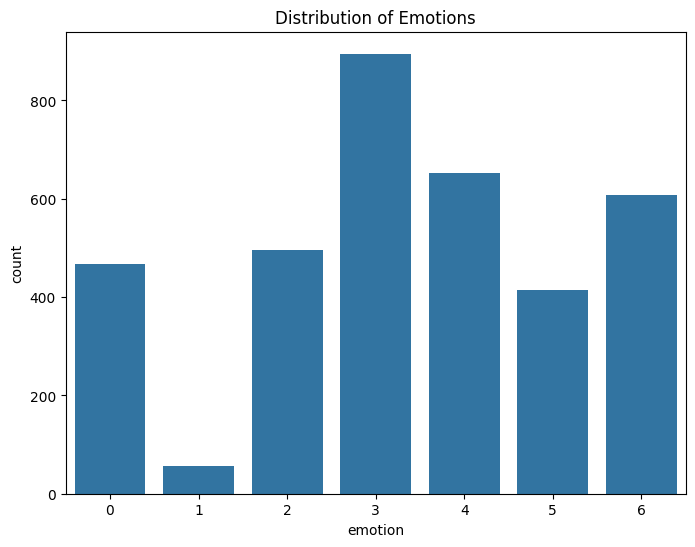

In [10]:
# Plot distribution of emotion
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='emotion')
plt.title("Distribution of Emotions")
plt.show()

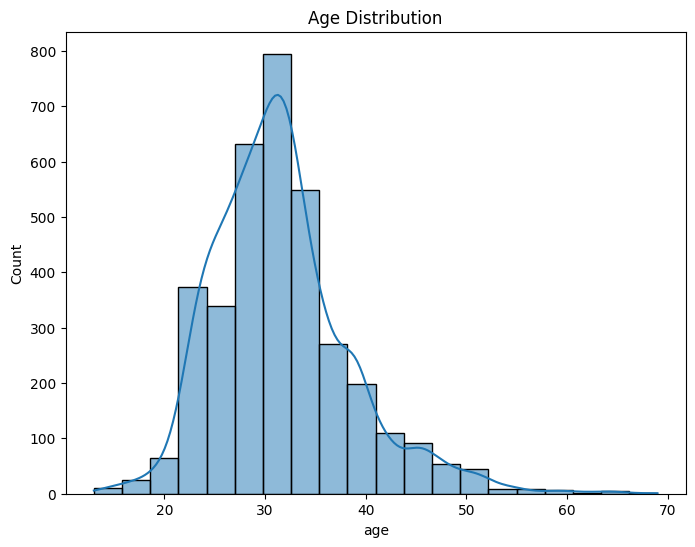

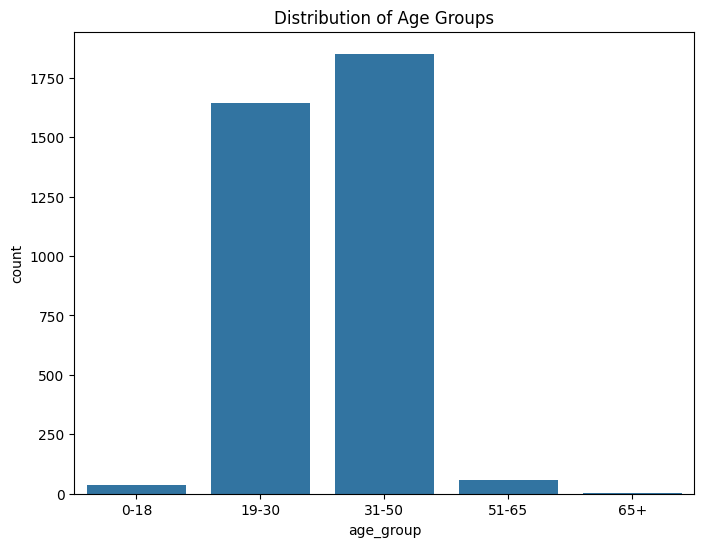

In [11]:
# Plot distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(data['age'], bins=20, kde=True)
plt.title("Age Distribution")
plt.show()

# Define age groups
age_bins = [0, 18, 30, 50, 65, 100]
age_labels = ['0-18', '19-30', '31-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels)

# Plot age groups
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='age_group')
plt.title("Distribution of Age Groups")
plt.show()


In [12]:
gender_percentage = data['gender'].value_counts(normalize=True) * 100
print(gender_percentage)

gender
Man      62.52438
Woman    37.47562
Name: proportion, dtype: float64


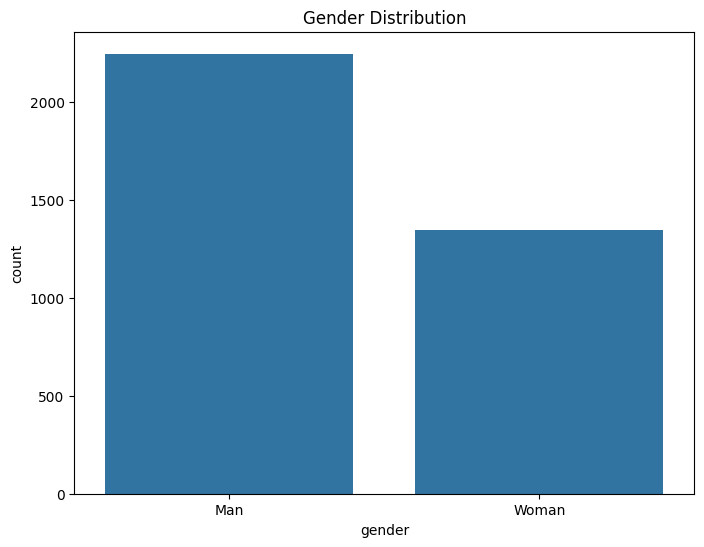

In [13]:
# Plot gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='gender')
plt.title("Gender Distribution")
plt.show()


### Emotion Distribution by Age Group

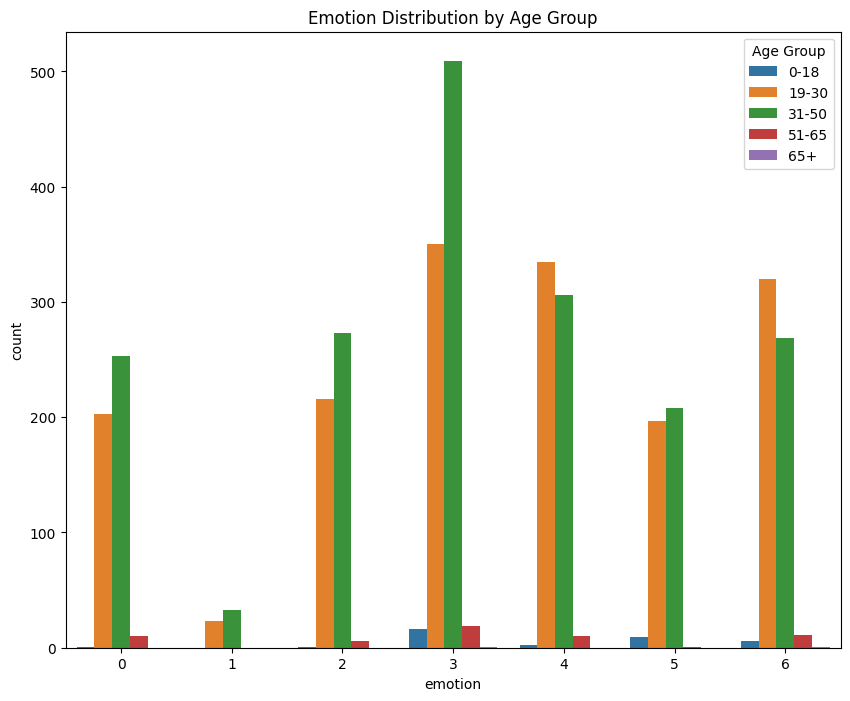

In [14]:
# Plot emotion distribution within each age group
plt.figure(figsize=(10, 8))
sns.countplot(data=data, x='emotion', hue='age_group')
plt.title("Emotion Distribution by Age Group")
plt.legend(title="Age Group")
plt.show()


### Emotion Distribution by Gender

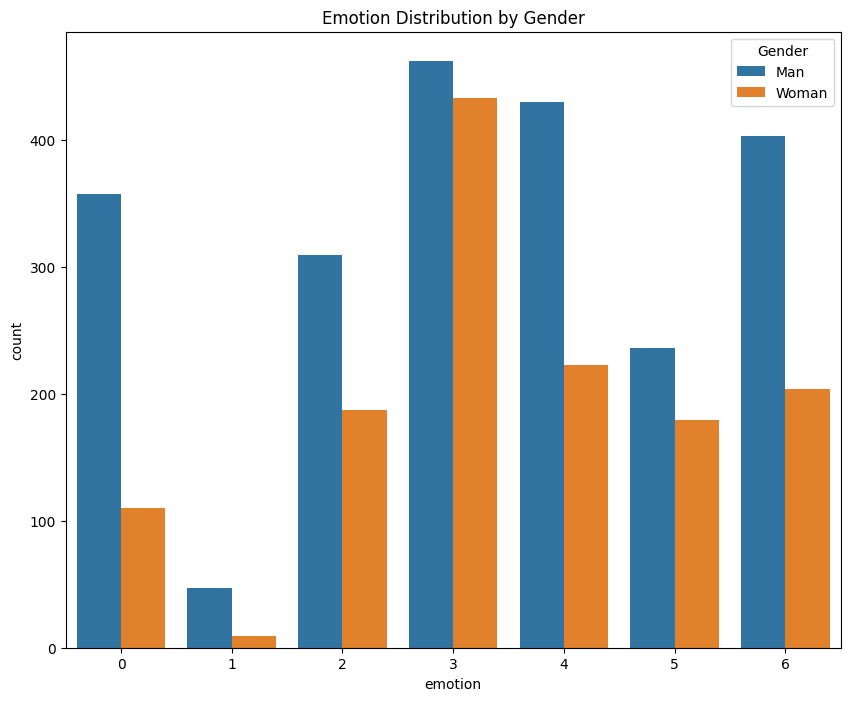

In [15]:
# Plot emotion distribution within each gender
plt.figure(figsize=(10, 8))
sns.countplot(data=data, x='emotion', hue='gender')
plt.title("Emotion Distribution by Gender")
plt.legend(title="Gender")
plt.show()


### Grouped Statistics

In [16]:
# Mean and count of each emotion by age group
emotion_by_age = data.groupby('age_group')['emotion'].value_counts(normalize=True).unstack()
print("Emotion Distribution by Age Group:\n", emotion_by_age)

# Mean and count of each emotion by gender
emotion_by_gender = data.groupby('gender')['emotion'].value_counts(normalize=True).unstack()
print("Emotion Distribution by Gender:\n", emotion_by_gender)


Emotion Distribution by Age Group:
 emotion           0         1         2         3         4         5  \
age_group                                                               
0-18       0.028571  0.000000  0.028571  0.457143  0.057143  0.257143   
19-30      0.123479  0.013990  0.131387  0.212895  0.203771  0.119830   
31-50      0.136683  0.017828  0.147488  0.274986  0.165316  0.112372   
51-65      0.175439  0.000000  0.105263  0.333333  0.175439  0.017544   
65+        0.000000  0.000000  0.000000  0.500000  0.000000  0.000000   

emotion           6  
age_group            
0-18       0.171429  
19-30      0.194647  
31-50      0.145327  
51-65      0.192982  
65+        0.500000  
Emotion Distribution by Gender:
 emotion         0         1         2         3         4         5         6
gender                                                                       
Man      0.159091  0.020945  0.137701  0.205882  0.191622  0.105169  0.179590
Woman    0.081784  0.006691  0.

<ipython-input-16-b4a2e438aab0>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emotion_by_age = data.groupby('age_group')['emotion'].value_counts(normalize=True).unstack()


### Correlation Analysis

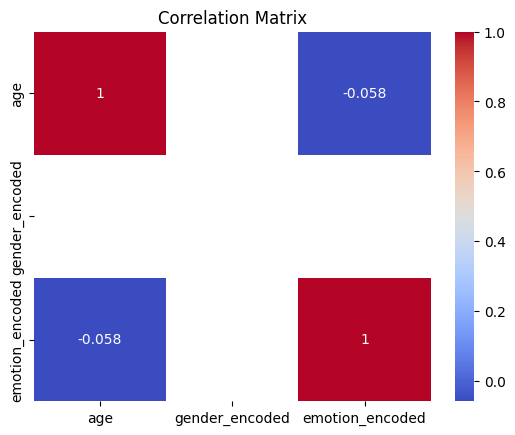

In [17]:
# Encode gender and emotion for correlation analysis
data['gender_encoded'] = data['gender'].map({'male': 0, 'female': 1})
data['emotion_encoded'] = data['emotion'].factorize()[0]

# Compute correlation matrix
corr_matrix = data[['age', 'gender_encoded', 'emotion_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Detecting Bias in Data:

- We’ve analyzed model performance across key demographic features: age group and gender. Using Fairlearn, we segmented the data into meaningful slices for each age-gender combination.
- This segmentation allows us to track accuracy and selection rate for each subgroup and identify discrepancies in model performance, which may indicate bias.

#Data Slicing for Bias Analysis

Install Fairlearn

In [18]:
!pip install -q fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.5 MB/s eta 0:00:00


Using a simple Neural Network to get model performance on different data slices

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Step 1: Data Loading and Preprocessing

def load_and_preprocess_data(data):
    """
    Converts pixel values from string format to numpy arrays and encodes target labels.

    Args:
        data (pd.DataFrame): DataFrame containing 'pixels' and 'emotion' columns.

    Returns:
        tuple: Features (X), encoded labels (y_encoded), and label encoder.
    """
    # Convert pixel values from space-separated strings to numpy arrays
    data['pixels'] = data['pixels'].apply(lambda x: np.array([int(i) for i in x.split()]) if isinstance(x, str) else x)
    X = np.array(data['pixels'].tolist())
    y = data['emotion']

    # Encode target labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X, y_encoded, label_encoder

# Step 2: Data Splitting and Normalization
def split_and_normalize_data(X, y, data, test_size=0.2, random_state=42):
    """
    Splits data into training and test sets, and normalizes pixel values.

    Args:
        X (np.ndarray): Feature data.
        y (np.ndarray): Encoded labels.
        data (pd.DataFrame): Original DataFrame to retain indices.
        test_size (float): Proportion of data for the test set.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: Training and test sets (X_train, X_test, y_train, y_test), and test indices.
    """
    # Split data, keeping track of indices for fairness analysis
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, data.index, test_size=test_size, random_state=random_state)

    # Normalize pixel values to be in the range [0, 1]
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test, indices_test

# Step 3: Model Definition
def define_model(input_shape, num_classes):
    """
    Defines a neural network model for image classification.

    Args:
        input_shape (int): Shape of the input data.
        num_classes (int): Number of classes for the output layer.

    Returns:
        tf.keras.Sequential: Compiled neural network model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Step 4: Model Compilation
def compile_model(model):
    """
    Compiles the neural network model with optimizer, loss, and metrics.

    Args:
        model (tf.keras.Model): Neural network model to compile.

    Returns:
        tf.keras.Model: Compiled model.
    """
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 5: Model Training
def train_model(model, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
    """
    Trains the model on the training data.

    Args:
        model (tf.keras.Model): Compiled model to train.
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size.
        validation_split (float): Fraction of training data used for validation.

    Returns:
        tuple: Trained model and training history.
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return model, history

# Step 6: Model Evaluation
def evaluate_model(model, X_test):
    """
    Evaluates the model on the test data and returns predictions.

    Args:
        model (tf.keras.Model): Trained model.
        X_test (np.ndarray): Test features.

    Returns:
        np.ndarray: Predicted labels for the test set.
    """
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    return y_pred

# Step 7: Fairness Analysis
def fairness_analysis(y_test, y_pred, data, indices_test):
    """
    Performs fairness analysis on the model's predictions using Fairlearn.

    Args:
        y_test (np.ndarray): True labels for the test set.
        y_pred (np.ndarray): Predicted labels for the test set.
        data (pd.DataFrame): Original DataFrame containing sensitive feature columns.
        indices_test (pd.Index): Indices for test data rows.

    Returns:
        MetricFrame: MetricFrame object with fairness metrics by group.
    """
    # Define sensitive feature slices (e.g., age group and gender)
    slices = {
        'emotion': data.loc[indices_test, 'emotion'],
        'age_group': data.loc[indices_test, 'age_group'],
        'gender': data.loc[indices_test, 'gender']
    }

    # Create a MetricFrame to analyze accuracy and selection rate by sensitive features
    metric_frame = MetricFrame(metrics={'accuracy': accuracy_score, 'selection_rate': selection_rate},
                               y_true=y_test, y_pred=y_pred, sensitive_features=slices)
    return metric_frame

# Main Function to Run All Steps
def main_model(data):
    """
    Main function to run the end-to-end process of data loading, preprocessing, training,
    evaluation, and fairness analysis.

    Args:
        data (pd.DataFrame): DataFrame containing image data, labels, and sensitive features.
    """
    # Step 1: Load and preprocess data
    X, y, label_encoder = load_and_preprocess_data(data)

    # Step 2: Split and normalize data
    X_train, X_test, y_train, y_test, indices_test = split_and_normalize_data(X, y, data)

    # Step 3: Define model
    model = define_model(input_shape=X_train.shape[1], num_classes=len(label_encoder.classes_))

    # Step 4: Compile model
    model = compile_model(model)

    # Step 5: Train model
    model, history = train_model(model, X_train, y_train)

    # Step 6: Evaluate model
    y_pred = evaluate_model(model, X_test)

    # Step 7: Fairness analysis
    metric_frame = fairness_analysis(y_test, y_pred, data, indices_test)

    # Display fairness analysis results
    print("Fairness Analysis Results:")
    print(metric_frame.by_group)

# Run the main function
main_model(data)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2090 - loss: 1.9464 - val_accuracy: 0.2730 - val_loss: 1.7972
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2531 - loss: 1.7966 - val_accuracy: 0.2887 - val_loss: 1.8262
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2618 - loss: 1.8017 - val_accuracy: 0.2817 - val_loss: 1.8184
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2769 - loss: 1.7542 - val_accuracy: 0.3148 - val_loss: 1.7724
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2870 - loss: 1.7560 - val_accuracy: 0.3113 - val_loss: 1.7522
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3107 - loss: 1.7166 - val_accuracy: 0.3200 - val_loss: 1.7298
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3197 - loss: 1.7123 - val_accuracy: 0.2609 - val_loss: 1.8287
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3242 - loss: 1.7087 - val_accuracy: 0.3061 - val_los

Data Slicing for Bias Analysis:
Using data slicing, we observe the following:

### Gender-Based Performance:

- Across most age groups, women generally achieve higher accuracy than men, indicating a possible gender bias in favor of women.
- In the 0-18 age group, the accuracy for women is notably higher at 0.75 compared to 0.5 for men.
- In the 51-65 age group, this trend reverses, with men achieving an accuracy of 0.75 compared to 0.5 for women.
- For the 65+ age group, accuracy for men is 0.0, whereas women have a perfect accuracy of 1.0, suggesting that the model may struggle to generalize for older men but may have overfit for older women in this particular age slice.

### Age-Based Performance:

- Accuracy generally fluctuates across age groups, indicating an age-related bias.
- Young adults (19-30 and 31-50 age groups) show lower accuracy scores than the 0-18 and 51-65 age groups, suggesting the model may perform better for younger or older adults than for individuals in middle adulthood.
- The 65+ age group has extreme results: while women in this group have an accuracy of 1.0, men in the same group have an accuracy of 0.0. This stark difference points to a bias related to age, possibly compounded by gender, where the model does not perform consistently across the oldest age slice.

### Selection Rate:

- The selection rate remains 0.0 across all subgroups, indicating that the model does not favor any subgroup in terms of positive predictions. This consistent selection rate could imply that the model might lack sufficient sensitivity or decision-making threshold adjustments for certain groups.